In [28]:
import tensorflow as tf
import numpy as np
import cv2
import timeit, time
import thop
import matplotlib.pyplot as plt
from model_profiler import model_profiler
from keras_flops import get_flops

In [2]:
print("Tensorflow version:{}".format(tf.__version__))

Tensorflow version:2.11.0


In [3]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = 0.25
# sess = tf.compat.v1.Session(config=config)

In [4]:
def read_image(file):
    feat, label = [], []
    with open(file) as f:
        for i in f:
            img_info = i.split(" ")
            
            img_name = img_info[0]
            img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(32,32))
            img_feat = img / 255.0
            img_feat = np.expand_dims(img_feat,axis=2)
            feat.append(img_feat)
            
            img_label = int(img_info[-1])
            onehot = np.zeros(50)
            onehot[img_label] = 1
            label.append(onehot)
            
        return np.array(feat), np.array(label)
            

In [5]:
%%time
train_img, train_label = read_image("train.txt")
val_img, val_label = read_image("val.txt")
test_img, test_label = read_image("test.txt")

CPU times: total: 38.3 s
Wall time: 38.4 s


# Tensorflow version

In [6]:
def create_dataset(img, label):
    ind = np.arange(len(img))
    np.random.shuffle(ind)
    dataset_ = tf.data.Dataset.from_tensor_slices((img[ind], label[ind]))
    ds = dataset_.repeat(25)
    ds = ds.batch(32)
    return ds

In [7]:
train_dataset = create_dataset(train_img, train_label)
val_dataset = create_dataset(val_img, val_label)

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),activation="sigmoid",input_shape=(32,32,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),activation="sigmoid",input_shape=(14,14,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120,activation="sigmoid"))
model.add(tf.keras.layers.Dense(84,activation="sigmoid"))
model.add(tf.keras.layers.Dense(50,activation="softmax"))

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [10]:
checkpoint_filepath = "hw3_best_model_tensorflow.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                                save_weights_only = True,
                                                                monitor = "val_accuracy",
                                                                save_best_only = True)

In [11]:
history = model.fit(train_dataset, epochs=25, callbacks=[model_checkpoint_callback], steps_per_epoch=1000, validation_data=val_dataset)

Epoch 1/25
1000/1000 [==============================] - 7s 6ms/step - loss: 3.9208 - accuracy: 0.0193 - val_loss: 3.9164 - val_accuracy: 0.0200
Epoch 2/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.8171 - accuracy: 0.0377 - val_loss: 3.7192 - val_accuracy: 0.0444
Epoch 3/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.7047 - accuracy: 0.0549 - val_loss: 3.6692 - val_accuracy: 0.0600
Epoch 4/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.6604 - accuracy: 0.0651 - val_loss: 3.6343 - val_accuracy: 0.0867
Epoch 5/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.6168 - accuracy: 0.0705 - val_loss: 3.5919 - val_accuracy: 0.0756
Epoch 6/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.5965 - accuracy: 0.0753 - val_loss: 3.5671 - val_accuracy: 0.0733
Epoch 7/25
1000/1000 [==============================] - 6s 6ms/step - loss: 3.5737 - accuracy: 0.0779 - val_loss: 3.5693 - val_accuracy:

Text(0.5, 1.0, 'Train/Validation Accuracy')

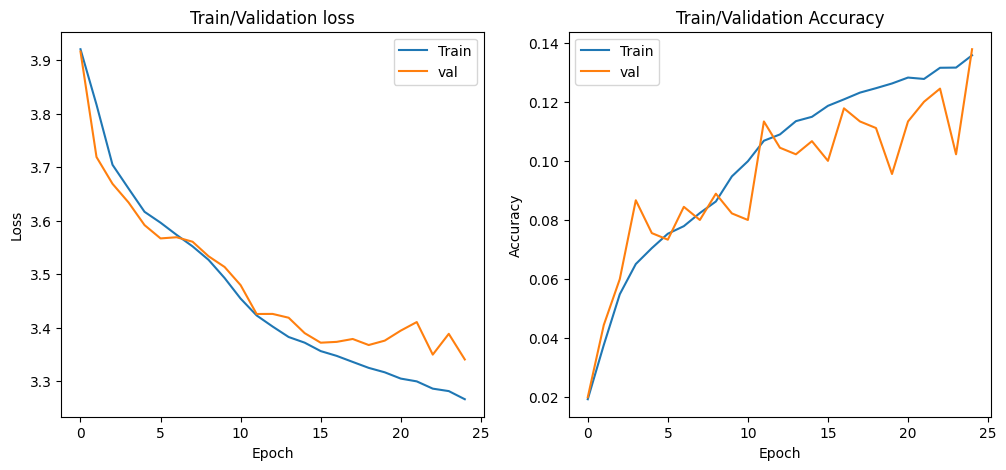

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation loss")

plt.subplot(122)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")

In [12]:
# load the best model
model.load_weights(checkpoint_filepath)

In [25]:
st_time = time.perf_counter()
pred = model.predict(test_img)
ed_time = time.perf_counter()
test_acc_count = (np.argmax(pred, axis=1) == np.argmax(test_label, axis=1)).sum()
print("Test accuracy: {}".format(test_acc_count/len(test_label)))
print("Inference time: {}s".format(ed_time-st_time))

15/15 [==============================] - 0s 2ms/step
Test accuracy: 0.17555555555555555
Inference time: 0.08817190000013397s


In [29]:
profile = model_profiler(model, Batch_size=32, use_units=["GPU IDs", "MFLOPs", "GB", "Million", "MB"])
print(profile)

flops = get_flops(model, batch_size=32)
print("FLOPs: {}G".format(round(flops/10**9,3)))

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0084        | MFLOPs  |
| GPU Memory Requirement           | 0.0011        | GB      |
| Model Parameters                 | 0.0651        | Million |
| Memory Required by Model Weights | 0.2484        | MB      |
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
FLOPs: 0.027G


# Static and Dynamic graph

In [44]:
# training time
@tf.function
def model_static(x, y):
    y_pred = model(x, training=True)
    return y_pred
def model_dynamic(x, y):
    y_pred = model(x, training=True)
    return y_pred

In [45]:
print("Static graph training time: {}s".format(timeit.timeit(lambda: model_static(train_img, train_label), number = 10)))
print("Dynamic graph training time: {}s".format(timeit.timeit(lambda: model_dynamic(train_img, train_label), number = 10)))

Static graph training time: 17.08932350000032s
Dynamic graph training time: 22.21594079999886s


In [41]:
# inference time
@tf.function
def model_static(x, y):
    y_pred = model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss
def model_dynamic(x, y):
    y_pred = model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss

In [42]:
print("Static graph inference time: {}s".format(timeit.timeit(lambda: model_static(test_img, test_label), number = 10)))
print("Dynamic graph inference time: {}s".format(timeit.timeit(lambda: model_dynamic(test_img, test_label), number = 10)))

Static graph inference time: 0.20844320000105654s
Dynamic graph inference time: 0.19282299999940733s
